# 1. Gerekli Kütüphanelerin Yüklenmesi

In [29]:
pip install scikit-learn keras torch torchvision requests scikeras

In [30]:
pip install scikeras

In [31]:
import torch
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
from keras.layers import Dense
from collections import Counter
import matplotlib.pyplot as plt
from keras.models import Sequential
from torchvision import datasets, transforms
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# 2. Veri Seti Yükleme ve Ön İşleme

## 1. Veri Yükleme

In [32]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize images to 32x32
    transforms.ToTensor(),
])

train_data = datasets.GTSRB(root='path/to/gtsrb_root/', split='train', download=True, transform=transform)
test_data = datasets.GTSRB(root='path/to/gtsrb_root/', split='test', download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=4, shuffle=True, num_workers=2)

Eğitim verilerinden örnek görüntüler:


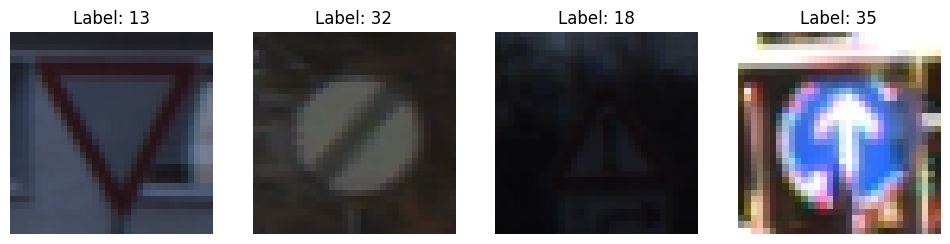

Test verilerinden örnek görüntüler:


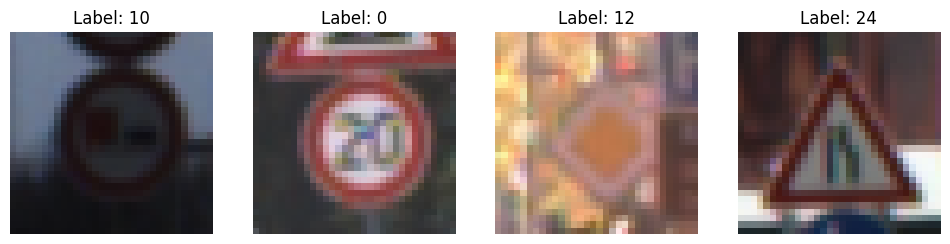

In [33]:
def show_images(loader):
    data_iter = iter(loader)
    images, labels = next(data_iter)
    fig, axes = plt.subplots(1, len(images), figsize=(12, 3))
    for i, img in enumerate(images):
        axes[i].imshow(img.permute(1, 2, 0))  # Permute to change tensor shape for matplotlib
        axes[i].set_title(f"Label: {labels[i].item()}")
        axes[i].axis('off')
    plt.show()

print("Eğitim verilerinden örnek görüntüler:")
show_images(train_loader)

print("Test verilerinden örnek görüntüler:")
show_images(test_loader)

## 2. Eksik Değerlerin İşlenmesi

Sınıflar arası farklar grafikte gözükmekte. Train ve test kümesi için frekans değerleri yazıyor. Eksik veri gözükmemekte.

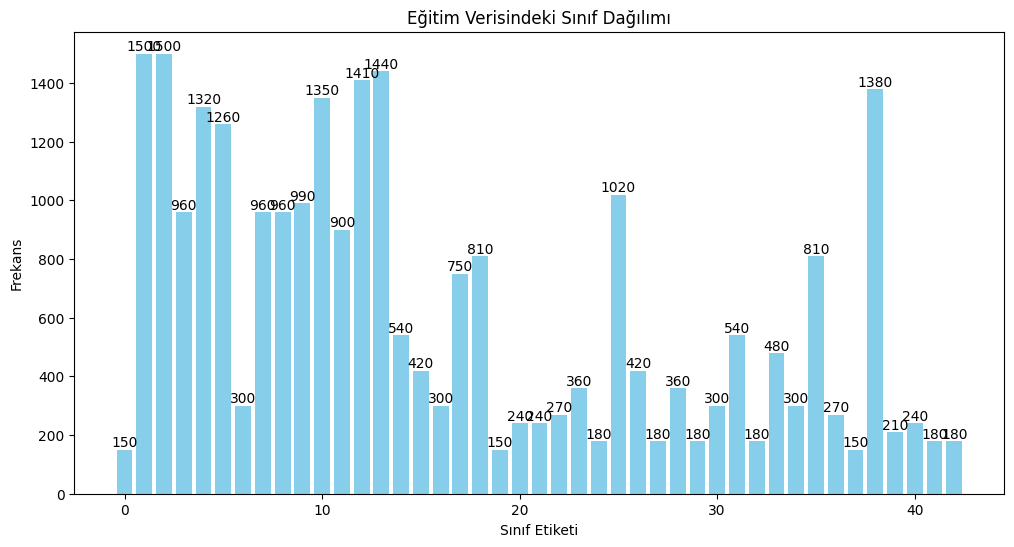

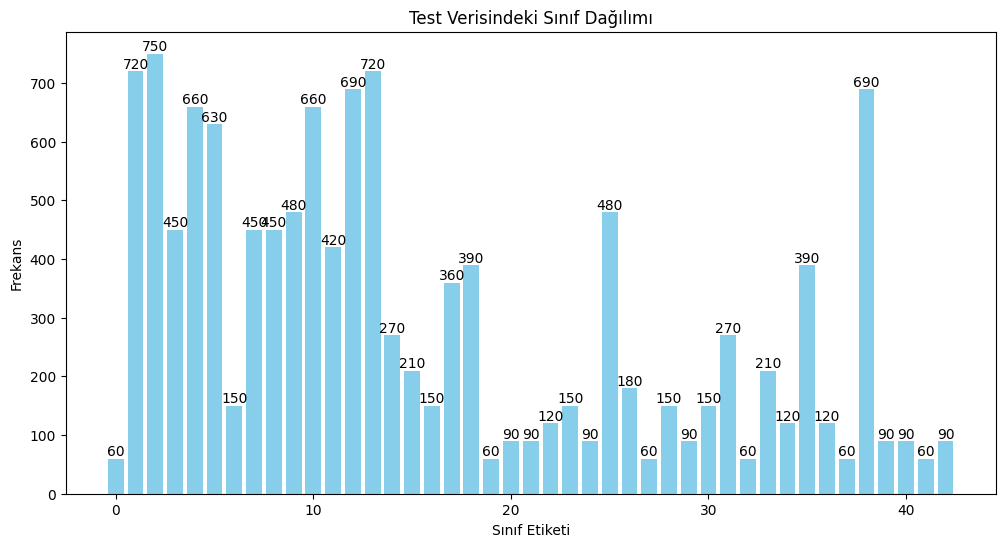

In [34]:
# Her bir veri kümesindeki sınıf dağılımlarını sayma
def count_labels(dataset):
    labels = [label for _, label in dataset]
    label_counts = Counter(labels)
    return label_counts

# Eğitim veri seti için sınıf frekanslarını hesaplama
train_labels = [label for _, label in train_data]
train_label_counts = Counter(train_labels)

# Test veri seti için sınıf frekanslarını hesaplama
test_labels = [label for _, label in test_data]
test_label_counts = Counter(test_labels)

# Histogram çizme fonksiyonu
def plot_histogram(label_counts, title):
    labels, counts = zip(*sorted(label_counts.items()))
    plt.figure(figsize=(12, 6))
    bars = plt.bar(labels, counts, color='skyblue')
    plt.title(title)
    plt.xlabel("Sınıf Etiketi")
    plt.ylabel("Frekans")

    # Çubukların üstüne frekans değerlerini ekleme
    for bar, count in zip(bars, counts):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count), ha='center', va='bottom')

    plt.show()

# Eğitim ve test veri setleri için histogramları çizdirme
plot_histogram(train_label_counts, "Eğitim Verisindeki Sınıf Dağılımı")
plot_histogram(test_label_counts, "Test Verisindeki Sınıf Dağılımı")

## 3. Veri Setini Eğitim ve Test Olarak Ayırma

In [35]:
# Eğitim verilerini ve etiketlerini ayırma
images = torch.stack([item[0] for item in train_data])  # Tüm görüntüleri alıyoruz
labels = torch.tensor([item[1] for item in train_data])  # Tüm etiketleri alıyoruz

# Veriyi 0.8 - 0.2 oranında ayırma
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

# Yeni veri setlerini TensorDataset'e dönüştürme
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

# DataLoader'ları oluşturma
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=True, num_workers=2)

## 4. Özellik Ölçekleme (Feature Scaling)

In [36]:
# StandartScaler ile veriyi ölçeklendirme
scaler = StandardScaler()

# X_train'in boyutunu (num_samples, features) olarak değiştirme
num_samples = X_train.shape[0]
num_features = X_train.shape[1] * X_train.shape[2] * X_train.shape[3]
X_train_reshaped = X_train.reshape(num_samples, num_features)

# Eğitim verilerini ölçeklendir
X_train_scaled = scaler.fit_transform(X_train_reshaped)

# X_val'in boyutunu da aynı şekilde değiştirme
num_samples_val = X_val.shape[0]
X_val_reshaped = X_val.reshape(num_samples_val, num_features)

# Doğrulama verilerini aynı scaler ile ölçeklendir
X_val_scaled = scaler.transform(X_val_reshaped)

# Ölçeklendirilmiş verileri orijinal şekline geri döndürme
X_train_scaled = torch.tensor(X_train_scaled.reshape(X_train.shape), dtype=torch.float32)
X_val_scaled = torch.tensor(X_val_scaled.reshape(X_val.shape), dtype=torch.float32)

# Yeni veri setlerini TensorDataset'e dönüştürme
train_dataset = TensorDataset(X_train_scaled, y_train)
val_dataset = TensorDataset(X_val_scaled, y_val)

# DataLoader'ları oluşturma
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=True, num_workers=2)

# 3. Model Eğitimi ve Hiperparametre Denemeleri

## 1. MLP Modeli

In [38]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import numpy as np

# 1. Eğitim ve doğrulama verilerini numpy dizilerine çevirme
X_train_np = X_train_scaled.numpy()
y_train_np = y_train.numpy()
X_val_np = X_val_scaled.numpy()
y_val_np = y_val.numpy()

# Reshape the input data to 2D before fitting the model
# Flatten the image data: (num_samples, channels, height, width) -> (num_samples, channels * height * width)
X_train_np = X_train_np.reshape(X_train_np.shape[0], -1)
X_val_np = X_val_np.reshape(X_val_np.shape[0], -1)

# 2. MLPClassifier ile model oluşturma
mlp = MLPClassifier(max_iter=1000)

# --- Modelin ilk halinin değerlendirilmesi ---
# Modeli eğitiyoruz
mlp.fit(X_train_np, y_train_np)

# İlk modelin tahminlerini yapma
y_pred_initial = mlp.predict(X_val_np)

# İlk modelin performans metriklerini hesaplama
print("Initial Model - Classification Report:")
print(classification_report(y_val_np, y_pred_initial))

# İlk modelin Confusion Matrix grafiğini çizme
conf_matrix_initial = confusion_matrix(y_val_np, y_pred_initial)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_initial, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_val_np), yticklabels=np.unique(y_val_np))
plt.title('Initial Model - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# --- Hiperparametre optimizasyonu ve GridSearchCV ile en iyi modelin eğitilmesi ---
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50), (100, 100)],  # Farklı gizli katman yapıları ve boyutları
    'activation': ['tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': [0.001, 0.01, 0.1],
    'learning_rate': ['adaptive'],
    'learning_rate_init': [0.001, 0.01, 0.1],
    'max_iter': [200, 300, 500]
}
# GridSearchCV ile çapraz doğrulama ve hiperparametre optimizasyonu
grid_search = GridSearchCV(mlp, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train_np, y_train_np)

# En iyi parametreleri yazdırma
print(f"En iyi parametreler: {grid_search.best_params_}")

# --- Hiperparametre optimizasyonu sonrası modelin değerlendirilmesi ---
# En iyi modelin tahminlerini yapma
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_val_np)

# En iyi modelin performans metriklerini hesaplama
print("Optimized Model - Classification Report:")
print(classification_report(y_val_np, y_pred_best))

# En iyi modelin Confusion Matrix grafiğini çizme
conf_matrix_best = confusion_matrix(y_val_np, y_pred_best)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_best, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_val_np), yticklabels=np.unique(y_val_np))
plt.title('Optimized Model - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# --- En iyi modelin kaydedilmesi ---
joblib.dump(best_model, 'best_mlp_model.pkl')


'from sklearn.neural_network import MLPClassifier\nfrom sklearn.model_selection import GridSearchCV\nfrom sklearn.metrics import classification_report, confusion_matrix\nimport matplotlib.pyplot as plt\nimport seaborn as sns\nimport joblib\nimport numpy as np\n\n# 1. Eğitim ve doğrulama verilerini numpy dizilerine çevirme\nX_train_np = X_train_scaled.numpy()\ny_train_np = y_train.numpy()\nX_val_np = X_val_scaled.numpy()\ny_val_np = y_val.numpy()\n\n# Reshape the input data to 2D before fitting the model\n# Flatten the image data: (num_samples, channels, height, width) -> (num_samples, channels * height * width)\nX_train_np = X_train_np.reshape(X_train_np.shape[0], -1)\nX_val_np = X_val_np.reshape(X_val_np.shape[0], -1)\n\n# 2. MLPClassifier ile model oluşturma\nmlp = MLPClassifier(max_iter=1000)\n\n# --- Modelin ilk halinin değerlendirilmesi ---\n# Modeli eğitiyoruz\nmlp.fit(X_train_np, y_train_np)\n\n# İlk modelin tahminlerini yapma\ny_pred_initial = mlp.predict(X_val_np)\n\n# İlk mod

## 2. RBF Modeli

In [40]:
import torch
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# 1. RBF modelini kuruyoruz
svm_model = SVC(kernel='rbf')

# --- Modelin ilk halinin değerlendirilmesi (hiperparametre optimizasyonu yapılmadan önce) ---

# Reshape X_train_scaled to 2D before fitting:
# Convert to NumPy array and flatten the image dimensions
X_train_reshaped = X_train_scaled.cpu().numpy().reshape(X_train_scaled.shape[0], -1)
# Convert to NumPy array for y_train
y_train_np = y_train.cpu().numpy()

# Fit the model with initial hyperparameters (no optimization)
svm_model.fit(X_train_reshaped, y_train_np)

# --- İlk modelin tahminlerini yapma ---
X_val_reshaped = X_val_scaled.cpu().numpy().reshape(X_val_scaled.shape[0], -1)  # Convert to NumPy array and flatten
y_val_np = y_val.cpu().numpy()  # Convert to NumPy array

# Tahminleri yapalım
y_pred_initial = svm_model.predict(X_val_reshaped)

# 2. İlk modelin performans metriklerini hesaplama
print("Initial Model - Classification Report:")
print(classification_report(y_val_np, y_pred_initial))

# 3. İlk modelin Confusion Matrix grafiği
cm_initial = confusion_matrix(y_val_np, y_pred_initial)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_initial, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Initial Model - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

conf_matrix_best = confusion_matrix(y_val_np, y_pred_initial)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_best, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_val_np), yticklabels=np.unique(y_val_np))
plt.title('Optimized Model - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# --- Hiperparametre optimizasyonu (GridSearchCV) ---

# Parametre  gridini belirleme
param_grid = {
    'C': [0.01, 1, 100],
    'gamma': [1, 0.1, 0.01],
    'kernel': ['rbf']
}
grid_search = GridSearchCV(SVC(), param_grid, cv=5, n_jobs=-1, scoring='accuracy')

# Fit GridSearchCV model using reshaped data
grid_search.fit(X_train_reshaped, y_train_np)

# En iyi parametreler
best_model = grid_search.best_estimator_

# 4. Hiperparametre optimizasyonu sonrası modelin tahminlerini yapma
y_pred_best = best_model.predict(X_val_reshaped)

# 5. Hiperparametre optimizasyonu sonrası performans metriklerini hesaplama
print("Optimized Model - Classification Report:")
print(classification_report(y_val_np, y_pred_best))

# 6. Hiperparametre optimizasyonu sonrası Confusion Matrix grafiği

cm_best = confusion_matrix(y_val_np, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Optimized Model - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


# En iyi modelin Confusion Matrix grafiğini çizme
conf_matrix_best = confusion_matrix(y_val_np, y_pred_best)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_best, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_val_np), yticklabels=np.unique(y_val_np))
plt.title('Optimized Model - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# 7. En iyi modelin kaydedilmesi
joblib.dump(best_model, 'best_rbf_svm_model.joblib')


SyntaxError: invalid syntax (<ipython-input-40-36f29d1227ba>, line 36)

Epoch 1/10
666/666 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.2053 - loss: 3.0808 - val_accuracy: 0.5480 - val_loss: 1.5598
Epoch 2/10
666/666 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6271 - loss: 1.2520 - val_accuracy: 0.7389 - val_loss: 0.8703
Epoch 3/10
666/666 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7706 - loss: 0.7515 - val_accuracy: 0.8405 - val_loss: 0.5666
Epoch 4/10
666/666 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8434 - loss: 0.5174 - val_accuracy: 0.8418 - val_loss: 0.5267
Epoch 5/10
666/666 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8546 - loss: 0.4697 - val_accuracy: 0.8720 - val_loss: 0.4458
Epoch 6/10
666/666 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8799 - loss: 0.3977 - val_accuracy: 0.8437 - val_loss: 0.5734
Epoch 7/10
666/666 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.8939 - loss: 0.3492 - val_accuracy: 0.8615 - val_loss: 0.4951
Epoch 8/10
666/666 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.9055 - loss: 0.3156 - val_accuracy

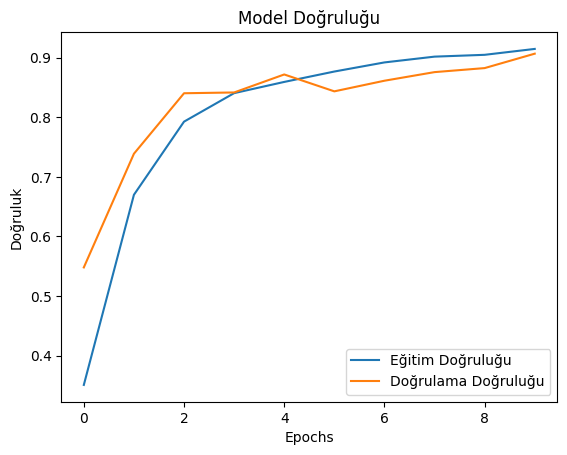

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy:  0.9069069069069069
F1 Score:  0.9070136159845725
Precision:  0.9119140625448604
Sensitivity (Recall):  0.9069069069069069


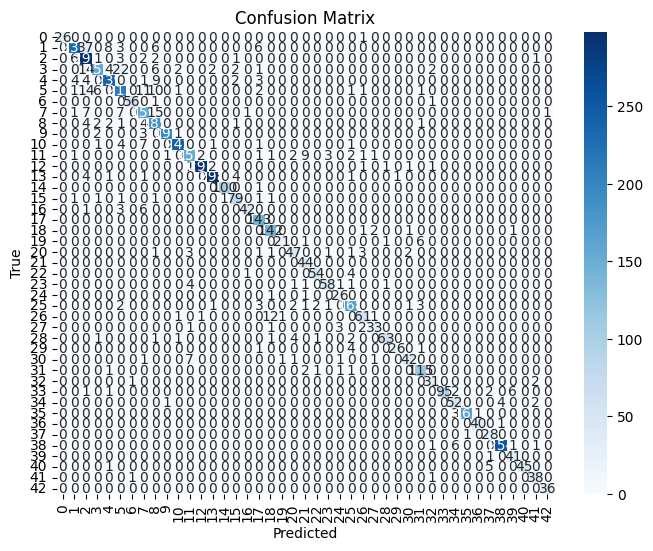

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64,), solver=adam; total time= 1.7min
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64,), solver=adam; total time= 1.4min
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64,), solver=adam; total time= 1.1min
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64,), solver=sgd; total time=13.1min
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64,), solver=sgd; total time=11.4min
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(64,), solver=sgd; total time=12.7min
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(128,), solver=adam; total time= 2.0min
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(128,), solver=adam; total time= 2.1min
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(128,), solver=adam; total time= 2.2min
[CV] END activation=relu, alpha=0.0001, hidden_layer_size

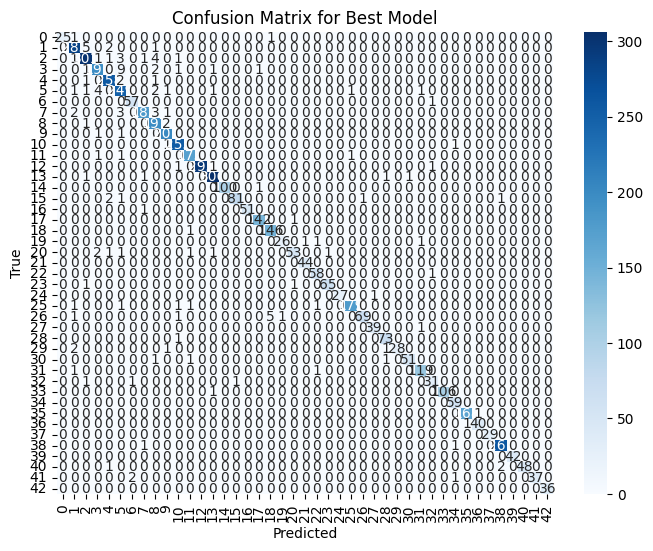

In [43]:
import torch
from torch import nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from keras import layers, models

# Veri setine göre sınıf sayısını otomatik olarak alalım
n_classes = len(np.unique(y_train))  # y_train, eğitim etiketleri

# Görüntü verisinin boyutunu 2D'ye dönüştürelim
X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], -1)  # [batch_size, width*height*channels]
X_val_scaled = X_val_scaled.reshape(X_val_scaled.shape[0], -1)  # [batch_size, width*height*channels]

# Modeli tanımlama
model = models.Sequential()

# Girdi katmanını ve RBF katmanını ekleyelim
model.add(layers.InputLayer(input_shape=(X_train_scaled.shape[1],)))

# RBF katmanı (gizli katman)
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(16, activation='relu'))

# Çıkış katmanını sınıf sayısına göre otomatik belirleyelim
model.add(layers.Dense(n_classes, activation='softmax'))  # Sınıf sayısına göre çıkış

# Modeli derleyelim
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Modeli eğitme
history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_data=(X_val_scaled, y_val))

# Eğitim ve doğrulama performansını grafikte gösterelim
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.xlabel('Epochs')
plt.ylabel('Doğruluk')
plt.legend()
plt.title('Model Doğruluğu')
plt.show()

# Modelin test verisi üzerindeki sonuçlarını değerlendirelim
y_pred = model.predict(X_val_scaled)
y_pred = np.argmax(y_pred, axis=1)

# Performans metriklerini hesaplayalım
acc = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred, average='weighted')
prec = precision_score(y_val, y_pred, average='weighted')
sens = recall_score(y_val, y_pred, average='weighted')

# Sonuçları yazdıralım
print("Accuracy: ", acc)
print("F1 Score: ", f1)
print("Precision: ", prec)
print("Sensitivity (Recall): ", sens)

# Confusion Matrix çizelim
conf_matrix = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_val), yticklabels=np.unique(y_val))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# GridSearchCV ile hiperparametre optimizasyonu
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier

# Modeli GridSearch ile optimize edelim
param_grid = {
    'hidden_layer_sizes': [(64,), (128,), (64, 32)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001]
}

# MLPClassifier kullanarak hiperparametre optimizasyonu
grid_search = GridSearchCV(MLPClassifier(max_iter=1000), param_grid, cv=3, scoring='accuracy', verbose=2)
grid_search.fit(X_train_scaled, y_train)

# En iyi parametreleri ve sonuçları yazdıralım
print("Best parameters found: ", grid_search.best_params_)
best_model = grid_search.best_estimator_

# En iyi model ile test sonucu
y_pred_best = best_model.predict(X_val_scaled)
acc_best = accuracy_score(y_val, y_pred_best)
f1_best = f1_score(y_val, y_pred_best, average='weighted')
prec_best = precision_score(y_val, y_pred_best, average='weighted')
sens_best = recall_score(y_val, y_pred_best, average='weighted')

# Sonuçları yazdıralım
print("Best Accuracy: ", acc_best)
print("Best F1 Score: ", f1_best)
print("Best Precision: ", prec_best)
print("Best Sensitivity (Recall): ", sens_best)

# Confusion matrix for best model
conf_matrix_best = confusion_matrix(y_val, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_best, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_val), yticklabels=np.unique(y_val))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Best Model')
plt.show()

# Modeli kaydedelim
model.save('traffic_sign_model.h5')
